# Spatial Integration of ST and MSI

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.image import DefaultImage, Annotation
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
from miit.registerers import GreedyFHistExt

### Load data

First we load both source and target sections.

In [10]:
reference_image_np = data=sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/reference_image.tif'))
reference_image = DefaultImage(data=reference_image_np)

tissue_mask_np = sitk.GetArrayViewFromImage(sitk.ReadImage('../data/hist/section1/tissue_mask.tif'))
tissue_mask = Annotation(data=tissue_mask_np, name='tissue_mask')

st_data = Visium.from_spcrng(directory='../data/visium/outs/')

target_section = Section(reference_image=reference_image,
                  annotations=[tissue_mask])
warped_st_data, registered_image = register_to_ref_image(target_section.reference_image.data, st_data.image.data, st_data)
target_section.so_data.append(warped_st_data)



msi_hist_image_path = '../data/hist/section2/reference_image.tif'
msi_hist_image = DefaultImage(data=sitk.GetArrayFromImage(sitk.ReadImage(msi_hist_image_path)))
imzml_path = '../data/msi_neg/data.imzML'


imzml = Imzml.load_msi_data(msi_hist_image,
                                  imzml_path,
                                  name='negative ion mode')

source_section = Section()
source_section.reference_image = msi_hist_image
source_section.so_data.append(imzml)

/mnt/work/maximilw/miniconda3/envs/miit2/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


### Registration

In [11]:
registerer = GreedyFHistExt.load_from_config()

In [12]:
transformation = registerer.register_images(
    moving_img=source_section.reference_image.data,
    fixed_img=target_section.reference_image.data
)

In [13]:
warped_section = source_section.apply_transform(registerer, transformation)

Text(0.5, 1.0, 'Registered Visium Section')

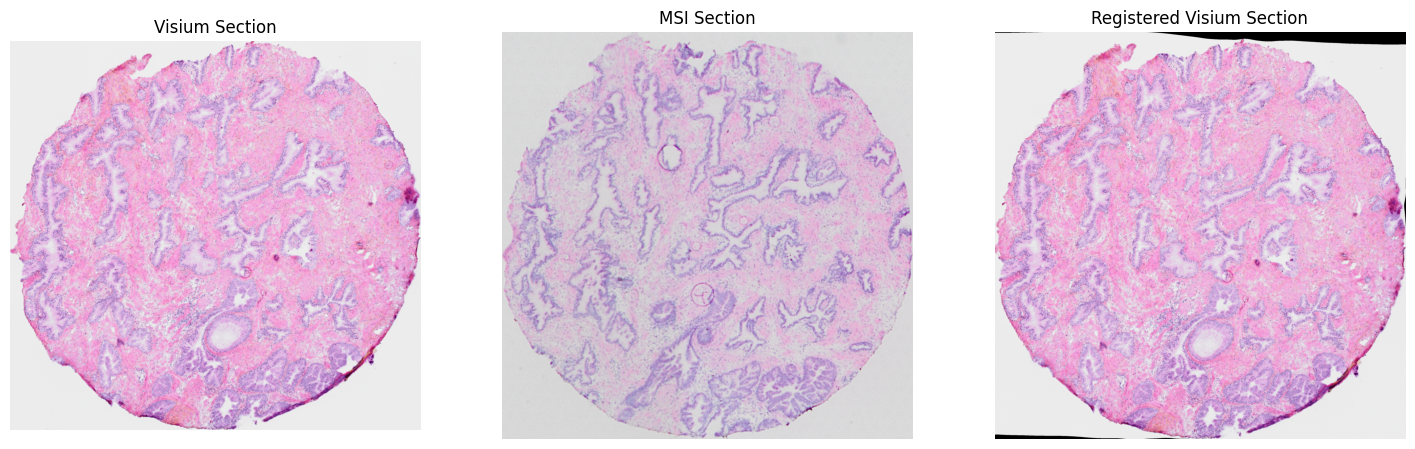

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(source_section.reference_image.data)
axs[0].set_title('Visium Section')
axs[1].imshow(target_section.reference_image.data)
axs[1].set_title('MSI Section')
axs[2].imshow(warped_section.reference_image.data)
axs[2].set_title('Registered Visium Section')

We can also show for the registration affects the reference matrix.

Text(0.5, 1.0, 'MSI Reference Matrix after Registration')

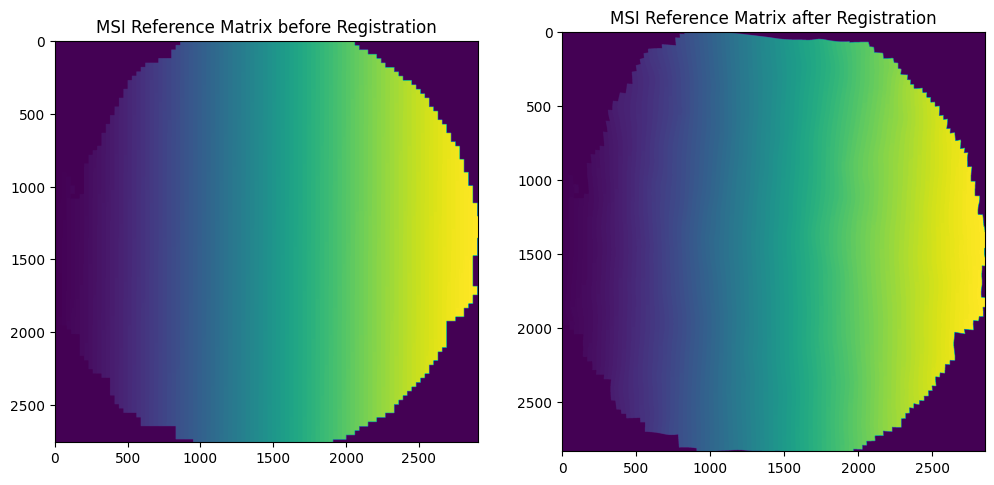

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
msi = source_section.so_data[0]
reg_msi = warped_section.so_data[0]
axs[0].imshow(msi.ref_mat.data)
axs[0].set_title('MSI Reference Matrix before Registration')
axs[1].imshow(reg_msi.ref_mat.data)
axs[1].set_title('MSI Reference Matrix after Registration')

### Integration

After all spatial data is aligned in the same coordinate system, the integration can start.

In [16]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    msi_default_accumulate_spot_weighted_mean, 
    msi_default_spot_accumulation_fun
)
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts,
    integrate_annotations
)
from pyimzml.ImzMLParser import ImzMLParser

Step 1: Find overlap between reference matrix. By default, 0 is assumed to denote the background in each reference matrix. `get_mappings` returns:

- `mapping`: a dictionary that maps for every unique reference id in the source reference matrix, the reference ids (including counts) in the target reference matrix. 
- `spots_background`: for each unique id in the source reference matrix the amount of overlap with background noise in the target reference matrix.
- `unique_target_reference`: A list of unique target references that have overlap with the source reference ids. 

In [17]:
st_data = target_section.so_data[0]
msi_data = warped_section.so_data[0] 
mappings, spots_background, unique_target_reference = get_mappings(st_data.ref_mat.data, msi_data.ref_mat.data, st_data.background, msi_data.background)

Step 2: We extract all intensities from the imzml file. We use the list unique references to only extract pixels which will be relevant for the subsequent merging. 

In [19]:
msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_data.config['imzml'])
# metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs, msi_pos_labels)
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

/mnt/work/maximilw/miniconda3/envs/miit2/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


,24,27,28,29,33,34,35,39,40,41,...,7338,7339,7340,7342,7343,7344,7345,7349,7350,7351
0.000,0.657107,0.254191,5.179552,0.950654,0.524526,1.007041,0.822705,0.288476,0.522138,0.986956,...,2.592139,0.746628,0.992277,2.175754,16.366716,1.394977,1.902068,0.975474,0.618040,1.144877
1.000,0.806916,1.066951,3.228607,0.690706,172.232742,1.326415,2.401599,0.409105,1.261841,1.281562,...,27.422232,3.363579,12.330980,4.068408,5.068223,1.996402,22.860813,1.231109,185.002304,0.328367
2.000,0.240061,2.282180,0.542377,2.839666,1.598247,1.135018,8.869605,7.631223,265.224304,1.648983,...,8.276652,1.011046,1.488991,5.024716,7.526261,2.008492,3.001752,0.857228,4.353659,8.457427
3.000,0.310404,205.383850,0.438812,0.647100,205.255661,0.817187,1.210441,1.278435,1.152715,2.307625,...,0.855088,1.680181,1.719360,11.781754,2.141965,14.744335,3.055336,1.341296,1.505044,1.102066
4.000,0.858339,2.129626,0.299882,0.098473,0.884394,0.496216,0.456821,2.277201,0.596770,1.388492,...,3.832047,0.686532,1.938882,15.919563,9.601240,5.312617,0.529010,13.883173,1.776496,1.371707


Step 3: We use the msi data and overlapping areas to accumulate the counts over the shared spatial transcriptomics spots.

In this example, we compute the weighted mean to accumulate spots using `msi_default_accumulate_spot_weighted_mean`. 

In [20]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,...,30.000,31.000,32.000,33.000,34.000,35.000,36.000,37.000,38.000,39.000
CGCGCCAAGCGATCAT-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CGGTGACCAGACAGCG-1,1.071837,1.538950,46.803542,12.516267,20.696708,1.975068,1.759158,1.539156,2.323525,1.421550,...,3.841765,1.520085,1.067253,67.403734,2.907125,3.740752,0.946485,5.169834,3.865225,29.624099
AATCTTAATTGTTGGT-1,20.254320,28.816973,2.374152,60.571673,1.714393,0.919833,17.860708,1.902459,13.192212,2.764905,...,2.020524,13.100904,1.461500,53.540705,0.867975,7.767132,1.144562,97.416401,5.598429,0.744998
AGGGCGTCCCATAGAC-1,71.917921,5.508336,30.943431,7.771653,6.885765,7.673675,4.806208,4.034618,15.869337,2.143016,...,1.432027,18.326323,3.602332,0.753510,1.148725,2.540058,0.664249,19.032985,1.375283,3.917073
CGGCTCTTAAAAACGA-1,10.370148,1.366302,1.255906,1.118065,8.265704,7.615226,3.402462,0.730487,1.631865,7.632943,...,1.790713,2.264840,0.433077,0.524062,0.412999,0.383132,0.368350,6.539112,0.873970,0.492704


An alternative to using the weighted mean to accumulate to spots, can be used with `msi_default_spot_accumulation_fun`. By default, this method accumulated using a number of standard statistical functions (i.e. max, mean median, min, std).

In [21]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_spot_accumulation_fun)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,max_0.000,mean_0.000,median_0.000,min_0.000,std_0.000,max_1.000,mean_1.000,median_1.000,min_1.000,std_1.000,...,median_8.000,min_8.000,std_8.000,max_9.000,mean_9.000,median_9.000,min_9.000,std_9.000,n_bck_pixls,n_pixels
CGCGCCAAGCGATCAT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1740,1740
CGGTGACCAGACAGCG-1,16.952631,1.071837,0.584046,0.0,2.043345,7.083193,1.538950,0.775500,0.0,1.561683,...,0.933465,0.0,1.875967,4.499593,1.421550,1.299002,0.0,1.142238,14,3041
AATCTTAATTGTTGGT-1,192.277527,20.254320,1.029959,0.0,55.285526,226.280045,28.816973,0.803941,0.0,72.683020,...,1.103370,0.0,45.435039,13.735960,2.764905,0.669944,0.0,4.194883,396,3029
AGGGCGTCCCATAGAC-1,249.998184,71.917921,1.150818,0.0,112.379933,33.721214,5.508336,0.681082,0.0,7.688436,...,28.519354,0.0,15.485416,37.454700,2.143016,0.860352,0.0,6.334008,1030,3031
CGGCTCTTAAAAACGA-1,233.065262,10.370148,0.000000,0.0,46.793963,6.004219,1.366302,0.000000,0.0,2.132565,...,0.000000,0.0,3.293491,39.087067,7.632943,0.000000,0.0,15.090566,1828,3005


Alternative functions for accumulation can be provided as well.